# **Homework 10 - Adversarial Attack**

Slides: https://reurl.cc/7DDxnD

Contact: ntu-ml-2022spring-ta@googlegroups.com


## Enviroment & Download

We make use of [pytorchcv](https://pypi.org/project/pytorchcv/) to obtain CIFAR-10 pretrained model, so we need to set up the enviroment first. We also need to download the data (200 images) which we want to attack.

In [1]:
# # set up environment
# !pip install pytorchcv
# !pip install imgaug

# # download
# !wget https://github.com/DanielLin94144/ML-attack-dataset/files/8167812/data.zip

# # unzip
# !unzip ./data.zip
# !rm ./data.zip

In [2]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 2

## Global Settings 
#### **[NOTE]**: Don't change the settings here, or your generated image might not meet the constraint.
* $\epsilon$ is fixed to be 8. But on **Data section**, we will first apply transforms on raw pixel value (0-255 scale) **by ToTensor (to 0-1 scale)** and then **Normalize (subtract mean divide std)**. $\epsilon$ should be set to $\frac{8}{255 * std}$ during attack.

* Explaination (optional)
    * Denote the first pixel of original image as $p$, and the first pixel of adversarial image as $a$.
    * The $\epsilon$ constraints tell us $\left| p-a \right| <= 8$.
    * ToTensor() can be seen as a function where $T(x) = x/255$.
    * Normalize() can be seen as a function where $N(x) = (x-mean)/std$ where $mean$ and $std$ are constants.
    * After applying ToTensor() and Normalize() on $p$ and $a$, the constraint becomes $\left| N(T(p))-N(T(a)) \right| = \left| \frac{\frac{p}{255}-mean}{std}-\frac{\frac{a}{255}-mean}{std} \right| = \frac{1}{255 * std} \left| p-a \right| <= \frac{8}{255 * std}.$
    * So, we should set $\epsilon$ to be $\frac{8}{255 * std}$ after ToTensor() and Normalize().

In [3]:
# the mean and std are the calculated statistics from cifar_10 dataset
cifar_10_mean = (0.491, 0.482, 0.447) # mean for the three channels of cifar_10 images
cifar_10_std = (0.202, 0.199, 0.201) # std for the three channels of cifar_10 images

# convert mean and std to 3-dimensional tensors for future operations
mean = torch.tensor(cifar_10_mean).to(device).view(3, 1, 1)
std = torch.tensor(cifar_10_std).to(device).view(3, 1, 1)

epsilon = 8/255/std

In [4]:
root = './data' # directory for storing benign images
# benign images: images which do not contain adversarial perturbations
# adversarial images: images which include adversarial perturbations

## Data

Construct dataset and dataloader from root directory. Note that we store the filename of each image for future usage.

In [5]:
import os
import glob
import shutil
import numpy as np
from PIL import Image
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_10_mean, cifar_10_std)
])

class AdvDataset(Dataset):
    def __init__(self, data_dir, transform):
        self.images = []
        self.labels = []
        self.names = []
        '''
        data_dir
        ├── class_dir
        │   ├── class1.png
        │   ├── ...
        │   ├── class20.png
        '''
        for i, class_dir in enumerate(sorted(glob.glob(f'{data_dir}/*'))):
            images = sorted(glob.glob(f'{class_dir}/*'))
            self.images += images
            self.labels += ([i] * len(images))
            self.names += [os.path.relpath(imgs, data_dir) for imgs in images]
        self.transform = transform
    def __getitem__(self, idx):
        image = self.transform(Image.open(self.images[idx]))
        label = self.labels[idx]
        return image, label
    def __getname__(self):
        return self.names
    def __len__(self):
        return len(self.images)

adv_set = AdvDataset(root, transform=transform)
adv_names = adv_set.__getname__()
adv_loader = DataLoader(adv_set, batch_size=batch_size, shuffle=False)

print(f'number of images = {adv_set.__len__()}')

number of images = 200


## Utils -- Benign Images Evaluation

In [6]:
# to evaluate the performance of model on benign images
def epoch_benign(model, loader, loss_fn):
    model.eval()
    train_acc, train_loss = 0.0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        yp = model(x)
        loss = loss_fn(yp, y)
        train_acc += (yp.argmax(dim=1) == y).sum().item()
        train_loss += loss.item() * x.shape[0]
    return train_acc / len(loader.dataset), train_loss / len(loader.dataset)

## Utils -- Attack Algorithm

In [7]:
# perform fgsm attack
def fgsm(model, x, y, loss_fn, epsilon=epsilon):
    x_adv = x.detach().clone() # initialize x_adv as original benign image x
    x_adv.requires_grad = True # need to obtain gradient of x_adv, thus set required grad
    loss = loss_fn(model(x_adv), y) # calculate loss
    loss.backward() # calculate gradient
    # fgsm: use gradient ascent on x_adv to maximize loss
    grad = x_adv.grad.detach()
    x_adv = x_adv + epsilon * grad.sign()
    return x_adv

# alpha and num_iter can be decided by yourself
alpha = 0.8/255/std
def ifgsm(model, x, y, loss_fn, epsilon=epsilon, alpha=alpha, num_iter=20):
    x_adv = x
    # write a loop of num_iter to represent the iterative times
    for i in range(num_iter):
        # x_adv = fgsm(model, x_adv, y, loss_fn, alpha) # call fgsm with (epsilon = alpha) to obtain new x_adv
        x_adv = x_adv.detach().clone()
        x_adv.requires_grad = True # need to obtain gradient of x_adv, thus set required grad
        loss = loss_fn(model(x_adv), y) # calculate loss
        loss.backward() # calculate gradient
        # fgsm: use gradient ascent on x_adv to maximize loss
        grad = x_adv.grad.detach()
        x_adv = x_adv + alpha * grad.sign()

        x_adv = torch.max(torch.min(x_adv, x+epsilon), x-epsilon) # clip new x_adv back to [x-epsilon, x+epsilon]
    return x_adv

def mifgsm(model, x, y, loss_fn, epsilon=epsilon, alpha=alpha, num_iter=20, decay=1.0):
    x_adv = x
    # initialze momentum tensor
    momentum = torch.zeros_like(x).detach().to(device)
    # write a loop of num_iter to represent the iterative times
    for i in range(num_iter):
        x_adv = x_adv.detach().clone()
        x_adv.requires_grad = True # need to obtain gradient of x_adv, thus set required grad
        loss = loss_fn(model(x_adv), y) # calculate loss
        loss.backward() # calculate gradient
        # TODO: Momentum calculation
        # grad = .....
        x_adv = x_adv + alpha * grad.sign()
        x_adv = torch.max(torch.min(x_adv, x+epsilon), x-epsilon) # clip new x_adv back to [x-epsilon, x+epsilon]
    return x_adv

# reference: https://github.com/cihangxie/DI-2-FGSM/blob/master/attack.py
# ref: https://github.com/Harry24k/adversarial-attacks-pytorch/blob/9f1969a7d5bf014b6a0d3aac84da41dbaedcd634/torchattacks/attacks/difgsm.py
def input_diversity(input_tensor):
    image_width = int(input_tensor.shape[-1] * 0.8)
    sz = input_tensor.shape[-1]

    rnd = torch.randint(image_width, sz, size=(1,), dtype=torch.int32)
    rescaled = F.interpolate(input_tensor, size=rnd)
    h_rem = sz - rnd
    w_rem = sz - rnd
    pad_top = torch.randint(0, h_rem.item(), size=(1,), dtype=torch.int32)
    pad_bottom = h_rem - pad_top
    pad_left = torch.randint(0, w_rem.item(), size=(1,), dtype=torch.int32)
    pad_right = w_rem - pad_left
    padded = F.pad(rescaled, (pad_left.item(), pad_right.item(), pad_top.item(), pad_bottom.item()), value=0)

    prob = torch.rand(1)
    if prob < 0.9:
        return padded
    else:
        return input_tensor


    # rnd = tf.random_uniform((), FLAGS.image_width, FLAGS.image_resize, dtype=tf.int32)
    # rescaled = tf.image.resize_images(input_tensor, [rnd, rnd], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # h_rem = FLAGS.image_resize - rnd
    # w_rem = FLAGS.image_resize - rnd
    # pad_top = tf.random_uniform((), 0, h_rem, dtype=tf.int32)
    # pad_bottom = h_rem - pad_top
    # pad_left = tf.random_uniform((), 0, w_rem, dtype=tf.int32)
    # pad_right = w_rem - pad_left
    # padded = tf.pad(rescaled, [[0, 0], [pad_top, pad_bottom], [pad_left, pad_right], [0, 0]], constant_values=0.)
    # padded.set_shape((input_tensor.shape[0], FLAGS.image_resize, FLAGS.image_resize, 3))
    # return tf.cond(tf.random_uniform(shape=[1])[0] < tf.constant(FLAGS.prob), lambda: padded, lambda: input_tensor)

def mifgsm_dim(model, x, y, loss_fn, epsilon=epsilon, alpha=alpha, num_iter=40, decay=1.0):
    x_adv = input_diversity(x)
    momentum = torch.zeros_like(x).detach().to(device)
    for i in range(num_iter):
        x_adv = x_adv.detach().clone()
        x_adv.requires_grad = True # need to obtain gradient of x_adv, thus set required grad
        loss = loss_fn(model(x_adv), y) # calculate loss
        loss.backward() # calculate gradient
        # TODO: Momentum calculation
        grad = x_adv.grad.detach()
        grad = grad / torch.mean(torch.abs(grad),(1,2,3),True)
        grad += decay * momentum
        momentum = grad
        x_adv = x_adv + alpha * grad.sign()
        x_adv = torch.max(torch.min(x_adv, x+epsilon), x-epsilon) # clip new x_adv back to [x-epsilon, x+epsilon]
    return x_adv

## Utils -- Attack
* Recall
  * ToTensor() can be seen as a function where $T(x) = x/255$.
  * Normalize() can be seen as a function where $N(x) = (x-mean)/std$ where $mean$ and $std$ are constants.

* Inverse function
  * Inverse Normalize() can be seen as a function where $N^{-1}(x) = x*std+mean$ where $mean$ and $std$ are constants.
  * Inverse ToTensor() can be seen as a function where $T^{-1}(x) = x*255$.

* Special Noted
  * ToTensor() will also convert the image from shape (height, width, channel) to shape (channel, height, width), so we also need to transpose the shape back to original shape.
  * Since our dataloader samples a batch of data, what we need here is to transpose **(batch_size, channel, height, width)** back to **(batch_size, height, width, channel)** using np.transpose.

In [8]:
# perform adversarial attack and generate adversarial examples
def gen_adv_examples(model, loader, attack, loss_fn):
    model.eval()
    adv_names = []
    train_acc, train_loss = 0.0, 0.0
    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        x_adv = attack(model, x, y, loss_fn) # obtain adversarial examples
        yp = model(x_adv)
        loss = loss_fn(yp, y)
        train_acc += (yp.argmax(dim=1) == y).sum().item()
        train_loss += loss.item() * x.shape[0]
        # store adversarial examples
        adv_ex = ((x_adv) * std + mean).clamp(0, 1) # to 0-1 scale
        adv_ex = (adv_ex * 255).clamp(0, 255) # 0-255 scale
        adv_ex = adv_ex.detach().cpu().data.numpy().round() # round to remove decimal part
        adv_ex = adv_ex.transpose((0, 2, 3, 1)) # transpose (bs, C, H, W) back to (bs, H, W, C)
        adv_examples = adv_ex if i == 0 else np.r_[adv_examples, adv_ex]
    return adv_examples, train_acc / len(loader.dataset), train_loss / len(loader.dataset)

# create directory which stores adversarial examples
def create_dir(data_dir, adv_dir, adv_examples, adv_names):
    if os.path.exists(adv_dir) is not True:
        _ = shutil.copytree(data_dir, adv_dir)
    for example, name in zip(adv_examples, adv_names):
        im = Image.fromarray(example.astype(np.uint8)) # image pixel value should be unsigned int
        im.save(os.path.join(adv_dir, name))

## Model / Loss Function

Model list is available [here](https://github.com/osmr/imgclsmob/blob/master/pytorch/pytorchcv/model_provider.py). Please select models which has _cifar10 suffix. Some of the models cannot be accessed/loaded. You can safely skip them since TA's model will not use those kinds of models.

In [9]:
from pytorchcv.model_provider import get_model as ptcv_get_model

In [10]:
class ensembleNet(nn.Module):
    def __init__(self, model_names):
        super().__init__()
        self.models = nn.ModuleList([ptcv_get_model(name, pretrained=True) for name in model_names])
        
    def forward(self, x):
        ensemble_logits = []
        for i, m in enumerate(self.models):
        # TODO: sum up logits from multiple models
              ensemble_logits.append(m(x.clone()))
        total = sum(ensemble_logits)
        return total / len(ensemble_logits)
        # return ensemble_logits

model_names = [
    'resnet110_cifar10',
    'resnet56_cifar10',
    'resnet20_cifar10',
    'resnet1001_cifar10',
    'seresnet110_cifar10',
    'seresnet164bn_cifar10',
    'sepreresnet20_cifar10',
    'densenet40_k12_cifar10',
    'densenet190_k40_bc_cifar10',
    'densenet100_k12_cifar10',
    'densenet40_k36_bc_cifar10',
    'resnext29_16x64d_cifar10',
    'preresnet110_cifar10',
    'diaresnet20_cifar10',
    'pyramidnet110_a48_cifar10',
    'densenet250_k24_bc_cifar10',
]
ensemble_model = ensembleNet(model_names).to(device)
ensemble_model.eval()

ensembleNet(
  (models): ModuleList(
    (0): CIFARResNet(
      (features): Sequential(
        (init_block): ConvBlock(
          (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activ): ReLU(inplace=True)
        )
        (stage1): Sequential(
          (unit1): ResUnit(
            (body): ResBlock(
              (conv1): ConvBlock(
                (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (activ): ReLU(inplace=True)
              )
              (conv2): ConvBlock(
                (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )

In [11]:
# model = ptcv_get_model('resnet110_cifar10', pretrained=True).to(device)
loss_fn = nn.CrossEntropyLoss()

benign_acc, benign_loss = epoch_benign(ensemble_model, adv_loader, loss_fn)
print(f'benign_acc = {benign_acc:.5f}, benign_loss = {benign_loss:.5f}')

benign_acc = 0.96000, benign_loss = 0.11118


## FGSM

In [12]:
# adv_examples, fgsm_acc, fgsm_loss = gen_adv_examples(ensemble_model, adv_loader, fgsm, loss_fn)
# print(f'fgsm_acc = {fgsm_acc:.5f}, fgsm_loss = {fgsm_loss:.5f}')

# create_dir(root, 'fgsm', adv_examples, adv_names)

## I-FGSM

In [13]:
# adv_examples, ifgsm_acc, ifgsm_loss = gen_adv_examples(ensemble_model, adv_loader, ifgsm, loss_fn)
# print(f'ifgsm_acc = {ifgsm_acc:.5f}, ifgsm_loss = {ifgsm_loss:.5f}')

# create_dir(root, 'ifgsm', adv_examples, adv_names)

In [14]:
adv_examples, mifgsm_dim_acc, mifgsm_dim_loss = gen_adv_examples(ensemble_model, adv_loader, mifgsm_dim, loss_fn)
print(f'mifgsm_dim_acc = {mifgsm_dim_acc:.5f}, mifgsm_dim_loss = {mifgsm_dim_loss:.5f}')

create_dir(root, 'mifgsm_dim', adv_examples, adv_names)

mifgsm_dim_acc = 0.00500, mifgsm_dim_loss = 13.16544


## Compress the images
* Submit the .tgz file to [JudgeBoi](https://ml.ee.ntu.edu.tw/hw10/)

In [15]:
# %cd fgsm
# !tar zcvf ../fgsm.tgz *
# %cd ..

# %cd ifgsm
# !tar zcvf ../ifgsm.tgz *
# %cd ..

%cd mifgsm_dim
!tar zcvf ../mifgsm_dim.tgz *
%cd ..

/home/tracy/Projects/ML2022/hw10/mifgsm_dim
airplane/
airplane/airplane2.png
airplane/airplane18.png
airplane/airplane20.png
airplane/airplane12.png
airplane/airplane5.png
airplane/airplane4.png
airplane/airplane15.png
airplane/airplane17.png
airplane/airplane1.png
airplane/airplane10.png
airplane/airplane7.png
airplane/airplane19.png
airplane/airplane11.png
airplane/airplane13.png
airplane/airplane9.png
airplane/airplane14.png
airplane/airplane16.png
airplane/airplane8.png
airplane/airplane3.png
airplane/airplane6.png
automobile/
automobile/automobile9.png
automobile/automobile18.png
automobile/automobile1.png
automobile/automobile19.png
automobile/automobile10.png
automobile/automobile8.png
automobile/automobile11.png
automobile/automobile15.png
automobile/automobile12.png
automobile/automobile16.png
automobile/automobile3.png
automobile/automobile5.png
automobile/automobile20.png
automobile/automobile17.png
automobile/automobile7.png
automobile/automobile4.png
automobile/automobile1

## Visualization

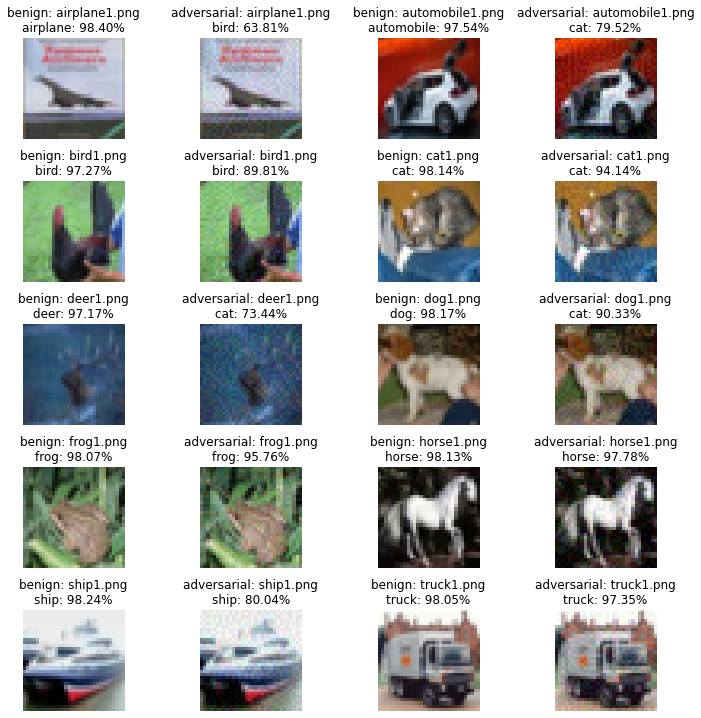

In [16]:
import matplotlib.pyplot as plt

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 20))
cnt = 0
for i, cls_name in enumerate(classes):
    path = f'{cls_name}/{cls_name}1.png'
    # benign image
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(f'./data/{path}')
    logit = ensemble_model(transform(im).unsqueeze(0).to(device))[0]
    predict = logit.argmax(-1).item()
    prob = logit.softmax(-1)[predict].item()
    plt.title(f'benign: {cls_name}1.png\n{classes[predict]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))
    # adversarial image
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(f'./fgsm/{path}')
    logit = ensemble_model(transform(im).unsqueeze(0).to(device))[0]
    predict = logit.argmax(-1).item()
    prob = logit.softmax(-1)[predict].item()
    plt.title(f'adversarial: {cls_name}1.png\n{classes[predict]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))
plt.tight_layout()
plt.show()

## Report Question
* Make sure you follow below setup: the source model is "resnet110_cifar10", applying the vanilla fgsm attack on `dog2.png`. You can find the perturbed image in `fgsm/dog2.png`.

In [17]:
# # original image
# path = f'dog/dog2.png'
# im = Image.open(f'./data/{path}')
# logit = model(transform(im).unsqueeze(0).to(device))[0]
# predict = logit.argmax(-1).item()
# prob = logit.softmax(-1)[predict].item()
# plt.title(f'benign: dog2.png\n{classes[predict]}: {prob:.2%}')
# plt.axis('off')
# plt.imshow(np.array(im))
# plt.tight_layout()
# plt.show()

# # adversarial image 
# adv_im = Image.open(f'./fgsm/{path}')
# logit = model(transform(adv_im).unsqueeze(0).to(device))[0]
# predict = logit.argmax(-1).item()
# prob = logit.softmax(-1)[predict].item()
# plt.title(f'adversarial: dog2.png\n{classes[predict]}: {prob:.2%}')
# plt.axis('off')
# plt.imshow(np.array(adv_im))
# plt.tight_layout()
# plt.show()


## Passive Defense - JPEG compression
JPEG compression by imgaug package, compression rate set to 70

Reference: https://imgaug.readthedocs.io/en/latest/source/api_augmenters_arithmetic.html#imgaug.augmenters.arithmetic.JpegCompression

In [18]:
# import imgaug.augmenters as iaa

# # pre-process image
# x = transforms.ToTensor()(adv_im)*255
# x = x.permute(1, 2, 0).numpy()
# x = x.astype(np.uint8)

# # TODO: use "imgaug" package to perform JPEG compression (compression rate = 70)
# # compressed_x =  ... x .. 

# logit = model(transform(compressed_x).unsqueeze(0).to(device))[0]
# predict = logit.argmax(-1).item()
# prob = logit.softmax(-1)[predict].item()
# plt.title(f'JPEG adversarial: dog2.png\n{classes[predict]}: {prob:.2%}')
# plt.axis('off')


# plt.imshow(compressed_x)
# plt.tight_layout()
# plt.show()